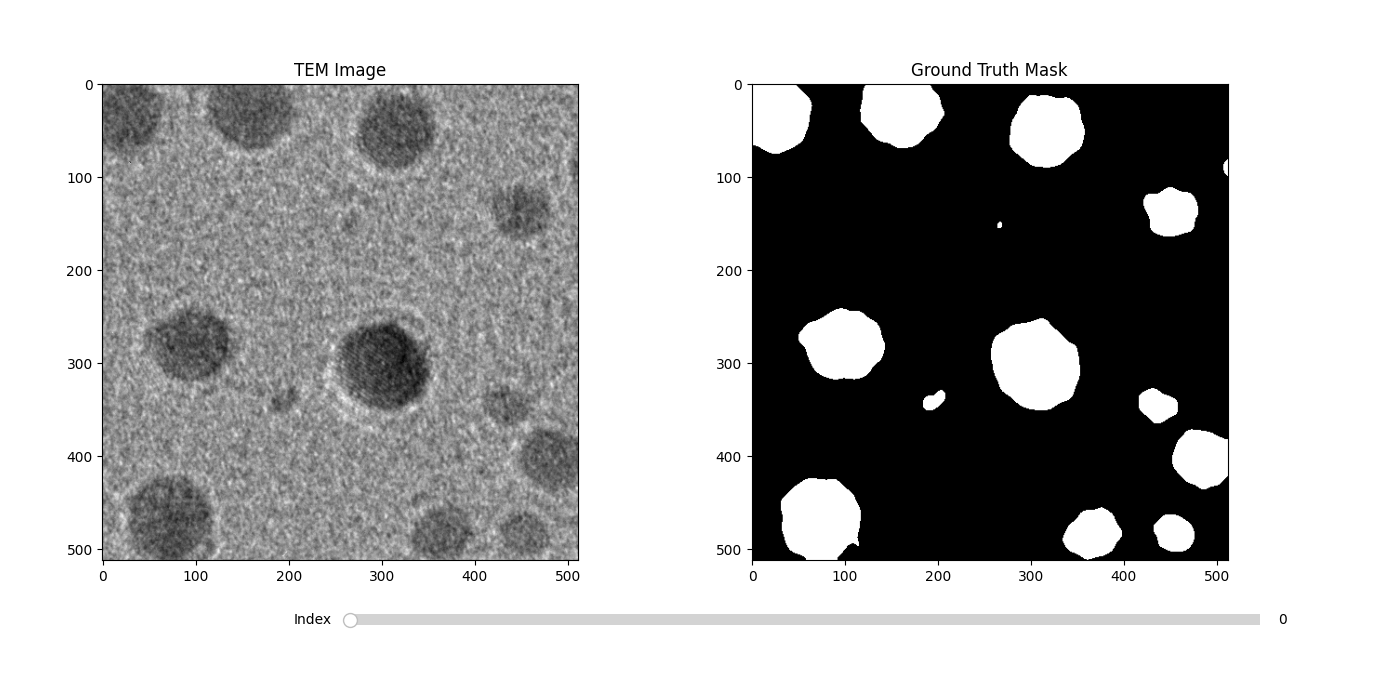

In [1]:
# Import necessary libraries
%matplotlib widget
import os
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import cv2
from pathlib import Path
from ipywidgets import HBox, ToggleButtons, VBox

# Set dataset paths
train_dataset_path = Path('./dataset/train/')
test_dataset_path = Path('./dataset/test/')

# Load images and labels from the dataset
def load_images_and_labels(dataset_path):
    image_dir = dataset_path / 'images'
    label_dir = dataset_path / 'labels'

    image_files = sorted(list(image_dir.glob('*.png')))
    label_files = sorted(list(label_dir.glob('*.png')))

    images = [cv2.imread(str(img), cv2.IMREAD_GRAYSCALE) for img in image_files]
    labels = [cv2.imread(str(lbl), cv2.IMREAD_GRAYSCALE) for lbl in label_files]

    return images, labels

# Load train and test datasets
train_images, train_labels = load_images_and_labels(train_dataset_path)
test_images, test_labels = load_images_and_labels(test_dataset_path)

# Set initial dataset to train
images, labels = train_images, train_labels

# Visualization setup
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.subplots_adjust(left=0.05, bottom=0.20)
fig.canvas.header_visible = False  # Hide title bar

# Initialize with the first image
image_display = ax[0].imshow(images[0], cmap='gray')
label_display = ax[1].imshow(labels[0], cmap='gray')

# Set titles
ax[0].set_title('TEM Image')
ax[1].set_title('Ground Truth Mask')

# Current image index
current_index = 0

# Sync zoom and pan between subplots
def on_zoom(event):
    if int(slider.val) == current_index:  # Sync only if index matches
        xlim_0, ylim_0 = ax[0].get_xlim(), ax[0].get_ylim()
        ax[1].set_xlim(xlim_0)
        ax[1].set_ylim(ylim_0)
        fig.canvas.draw_idle()

# Connect the zoom/pan sync event
fig.canvas.mpl_connect('motion_notify_event', on_zoom)

# Slider setup
ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Index', 0, len(images) - 1, valinit=0, valstep=1)

# Slider update function
def update(val):
    global current_index
    idx = int(slider.val)

    if idx != current_index:  # Reset view on image change
        image_display.set_data(images[idx])
        label_display.set_data(labels[idx])

        ax[0].set_xlim(0, images[idx].shape[1])
        ax[0].set_ylim(images[idx].shape[0], 0)
        ax[1].set_xlim(0, labels[idx].shape[1])
        ax[1].set_ylim(labels[idx].shape[0], 0)

        current_index = idx

    fig.canvas.draw_idle()

# Connect slider to update function
slider.on_changed(update)

# Toggle between train and test datasets
def update_dataset(change):
    global images, labels
    if toggle_buttons.value == 'Train':
        images, labels = train_images, train_labels
    else:
        images, labels = test_images, test_labels

    # Update slider range
    slider.valmax = len(images) - 1

    # Trigger update by forcing slider to refresh
    slider.set_val(-1)  # Force invalid value
    slider.set_val(0)   # Reset to 0

    update(0)  # Update displayed image

# Create dataset toggle buttons
toggle_buttons = ToggleButtons(
    options=['Train', 'Test'],
    description='Dataset:',
    disabled=False,
    button_style=''
)

# Connect toggle buttons to dataset switch function
toggle_buttons.observe(update_dataset, names='value')

# Display controls and images
controls = VBox([toggle_buttons])
display(HBox([controls]))

# Show the plot
plt.show()